In [1]:
load("ProcessData.RData")
library(ggplot2)
library(dplyr)
library(tidyverse)
library(tidyr)
library(broom)




Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ lubridate 1.9.4     ✔ tibble    3.3.1
✔ purrr     1.2.0     ✔ tidyr     1.3.2
✔ readr     2.1.6     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [ ]:
library(MASS)

library(stringr)
library(cowplot)
library(forcats)
library(ggpmisc)
library(patchwork)
library(ggnewscale)
library(RColorBrewer)
library(rstatix)
library(readr)
library(mutspecdist)
library(sigfit)

Figure 3
Compare snv/indel trends regionally
Signatures (+/- Lee-Six?)
Maybe add the Diaz-gay? Can add SNV trend w/o regionality?
Supplementary Table 11 & 12



"Cornish style"

term,estimate,std.error,statistic,p.value,p_bonf
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-6.761078e-16,0.4056323,-1.666800e-15,1.0000000,1.0000000
region_z,4.584974e-01,0.4443479,1.031843e+00,0.3604465,0.7208931


term,estimate,std.error,statistic,p.value,p_bonf
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.558648e-17,0.2558975,6.090907e-17,1.00000000,1.00000000
region_z,8.280575e-01,0.2803216,2.953955e+00,0.04180468,0.08360935


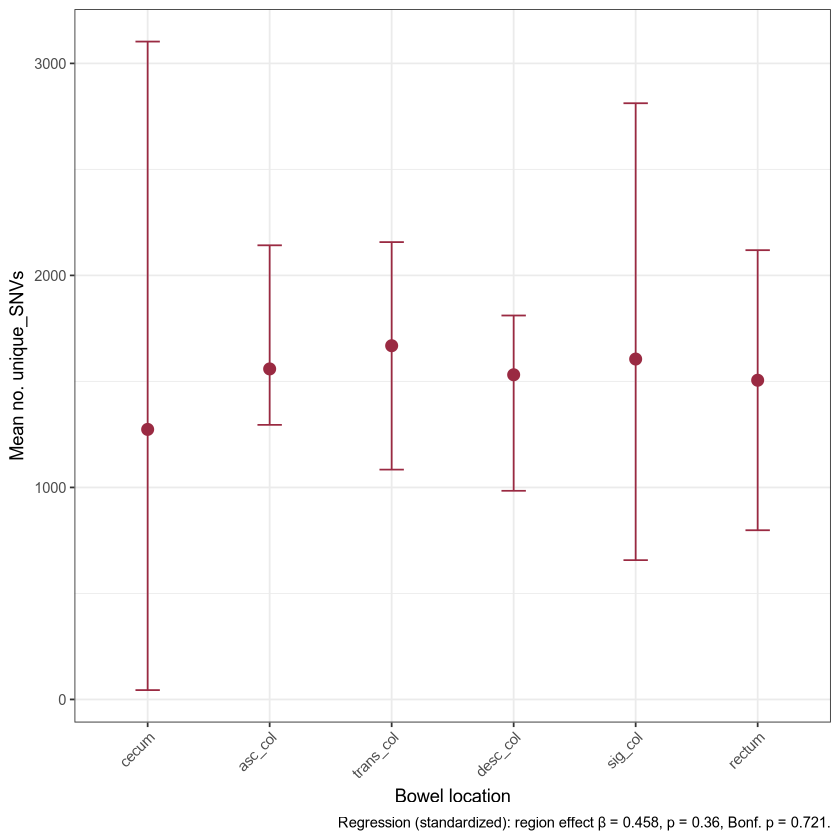

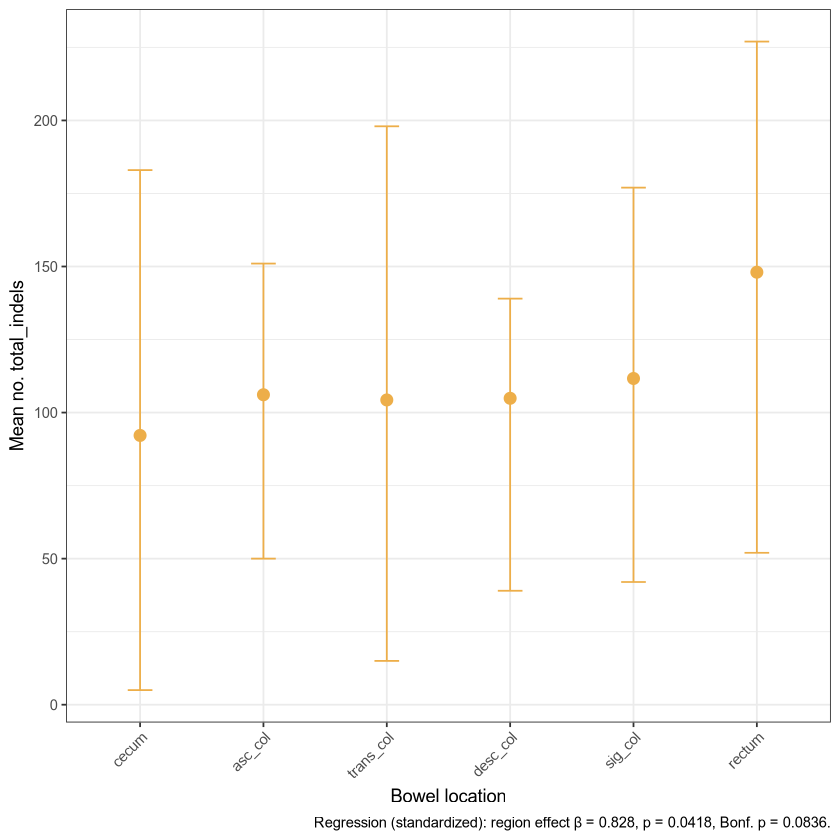

In [6]:
Cornish_site_SNV <- data.frame(
                       stringsAsFactors = FALSE,
  primary_tumour_site_more_specific_idx = c("cecum","asc_col","HF",
                                            "trans_col","SF","desc_col",
                                            "sig_col","RS","rectum"),
                             n_snv_Mean = c(14467,14563,14701,
                                            14747,12253,13149,12554,10686,11235),
                                 Median = c(13318,13544,12817,
                                            12867,10507,11826,10725,9496,10176),
                                Minimum = c(5008,6016,7739,5370,
                                            5449,4006,5018,4703,3402),
                                Maximum = c(43732,48510,46033,
                                            43643,23472,42561,47847,27835,42638),
                     Standard.Deviation = c(6378,6636,7974,6842,
                                            5061,7280,6289,4093,5427),
                    Interquartile.Range = c(6428,6362,5398,8255,
                                            6188,6751,5944,4270,5162),
                              n.tumours = c(158L,79L,21L,60L,21L,
                                            34L,262L,98L,173L)
)


Cornish_site_SNVs <- tibble::tribble(
  ~region_key, ~Cornish_Mean, ~Cornish_Median, ~Cornish_Minimum, ~Cornish_Maximum,
  "cecum",   14467, 13318, 5008,  43732,
  "asc_col", 14563, 13544, 6016,  48510,
  "HF",      14701, 12817, 7739,  46033,
  "trans_col",14747,12867, 5370,  43643,
  "SF",      12253, 10507, 5449,  23472,
  "desc_col",13149,11826, 4006,  42561,
  "sig_col", 12554,10725, 5018,  47847,
  "RS",      10686, 9496,  4703,  27835,
  "rectum",  11235,10176, 3402,  42638
)

region_levels <- c("cecum","asc_col","HF",
                                            "trans_col","SF","desc_col",
                                            "sig_col","RS","rectum")

Hiatt2 <- subset(Hiatt, cohort == "adenoma")

summary_uniqueSNVs <- Hiatt2 %>%
  group_by(region) %>%
  summarise(
    Mean = mean(unique_SNVs, na.rm = TRUE),
    Median = median(unique_SNVs, na.rm = TRUE),
    Minimum = min(unique_SNVs, na.rm = TRUE),
    Maximum = max(unique_SNVs, na.rm = TRUE),
    SD = sd(unique_SNVs, na.rm = TRUE),
    IQR = IQR(unique_SNVs, na.rm = TRUE),
    n_crypts = n()
  ) %>%
  arrange(factor(region, levels = c(
    "cecum", "asc_col", "HF", "trans_col", "SF",
    "desc_col", "sig_col", "RS", "rectum"
  )))



# Standardize predictors and outcome
dat_scaled <- summary_uniqueSNVs %>%
  mutate(
    Mean_z = scale(Mean),
    region_z = scale(as.numeric(factor(region)))   # or your real predictors
  )

# Fit regression model
fit <- lm(Mean_z ~ region_z, data = dat_scaled)

# Tidy results with Bonferroni correction
stats_tbl <- tidy(fit) %>%
  mutate(p_bonf = p.adjust(p.value, method = "bonferroni"))

stats_tbl


stat_caption <- paste0(
  "Regression (standardized): region effect β = ",
  round(stats_tbl$estimate[2], 3),
  ", p = ", signif(stats_tbl$p.value[2], 3),
  ", Bonf. p = ", signif(stats_tbl$p_bonf[2], 3), "."
)

ggplot(summary_uniqueSNVs,
       aes(x = region, y = Mean)) +
  geom_point(size = 3, color = "#9A2A42") +
  geom_errorbar(aes(ymin = Minimum, ymax = Maximum),
                width = 0.2, color = "#9A2A42") +
  theme_bw() +
  labs(
    x = "Bowel location",
    y = "Mean no. unique_SNVs",
    caption = stat_caption
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


summary_uniqueSNVs <- Hiatt %>%
  group_by(region) %>%
  summarise(
    Mean = mean(total_indels, na.rm = TRUE),
    Median = median(total_indels, na.rm = TRUE),
    Minimum = min(total_indels, na.rm = TRUE),
    Maximum = max(total_indels, na.rm = TRUE),
    SD = sd(total_indels, na.rm = TRUE),
    IQR = IQR(total_indels, na.rm = TRUE),
    n_crypts = n()
  ) %>%
  arrange(factor(region, levels = c(
    "cecum", "asc_col", "HF", "trans_col", "SF",
    "desc_col", "sig_col", "RS", "rectum"
  )))



# Standardize predictors and outcome
dat_scaled <- summary_uniqueSNVs %>%
  mutate(
    Mean_z = scale(Mean),
    region_z = scale(as.numeric(factor(region)))   # or your real predictors
  )

# Fit regression model
fit <- lm(Mean_z ~ region_z, data = dat_scaled)

# Tidy results with Bonferroni correction
stats_tbl <- tidy(fit) %>%
  mutate(p_bonf = p.adjust(p.value, method = "bonferroni"))

stats_tbl


stat_caption <- paste0(
  "Regression (standardized): region effect β = ",
  round(stats_tbl$estimate[2], 3),
  ", p = ", signif(stats_tbl$p.value[2], 3),
  ", Bonf. p = ", signif(stats_tbl$p_bonf[2], 3), "."
)

ggplot(summary_uniqueSNVs,
       aes(x = region, y = Mean)) +
  geom_point(size = 3, color = "#edae49") +
  geom_errorbar(aes(ymin = Minimum, ymax = Maximum),
                width = 0.2, color = "#edae49") +
  theme_bw() +
  labs(
    x = "Bowel location",
    y = "Mean no. total_indels",
    caption = stat_caption
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))






"Cornish comparison"

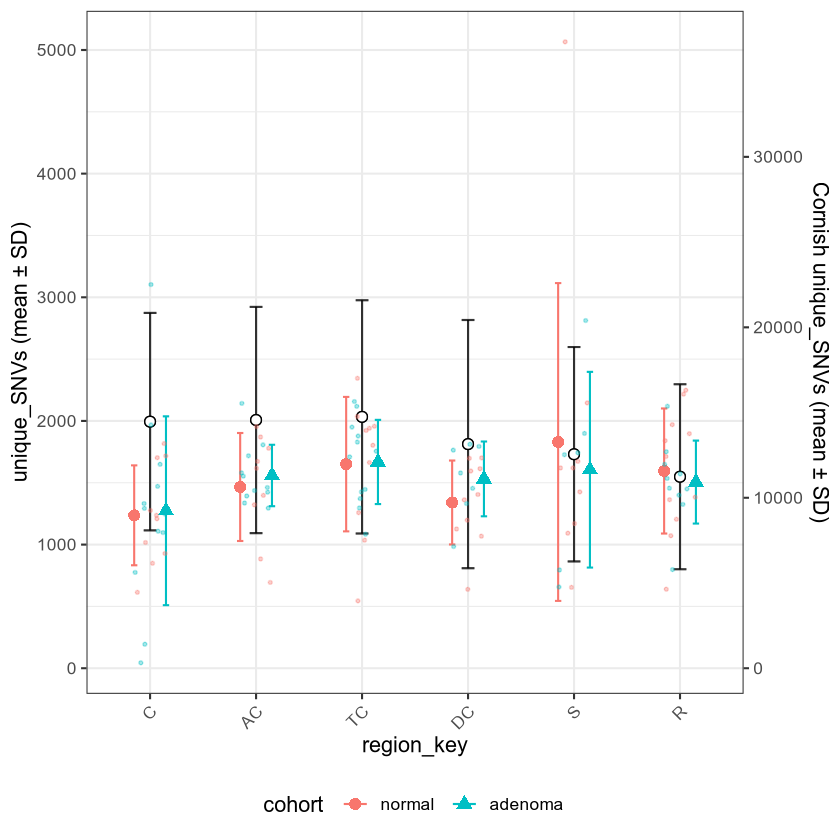

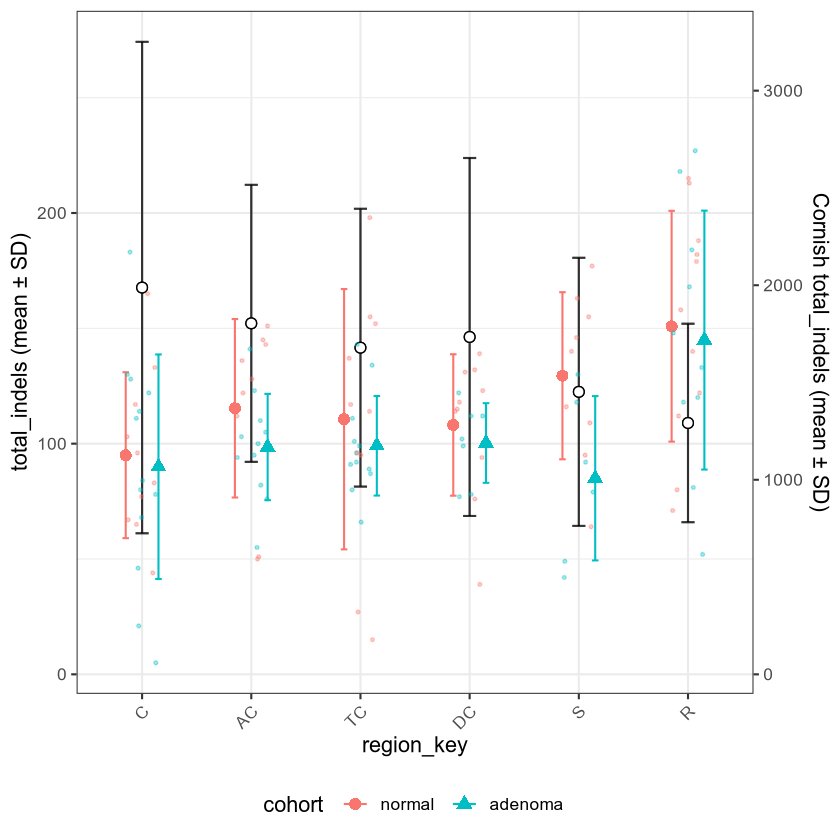

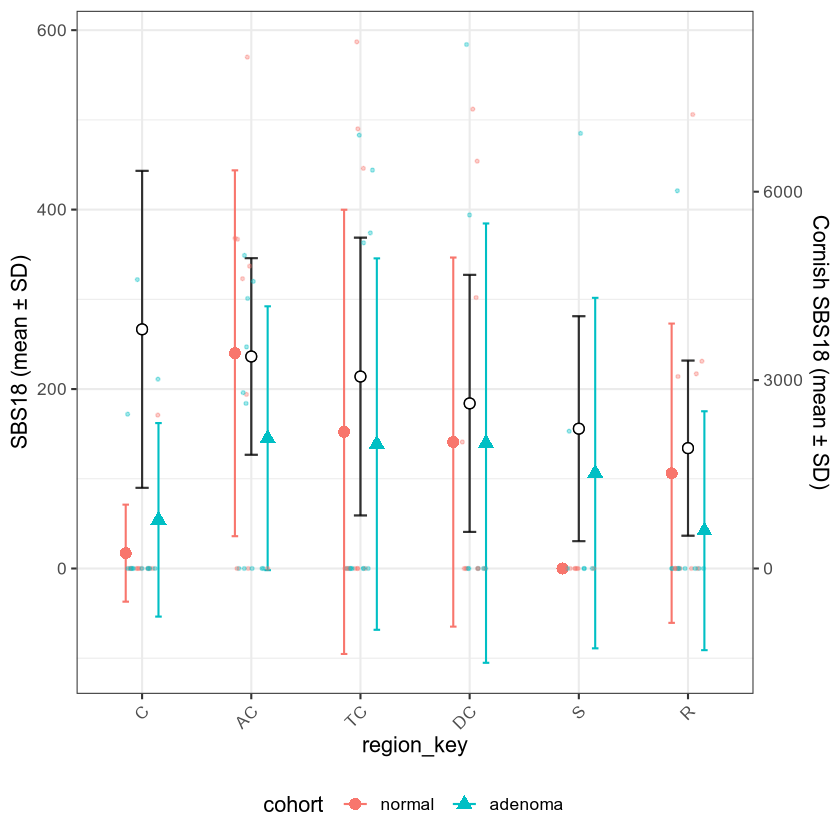

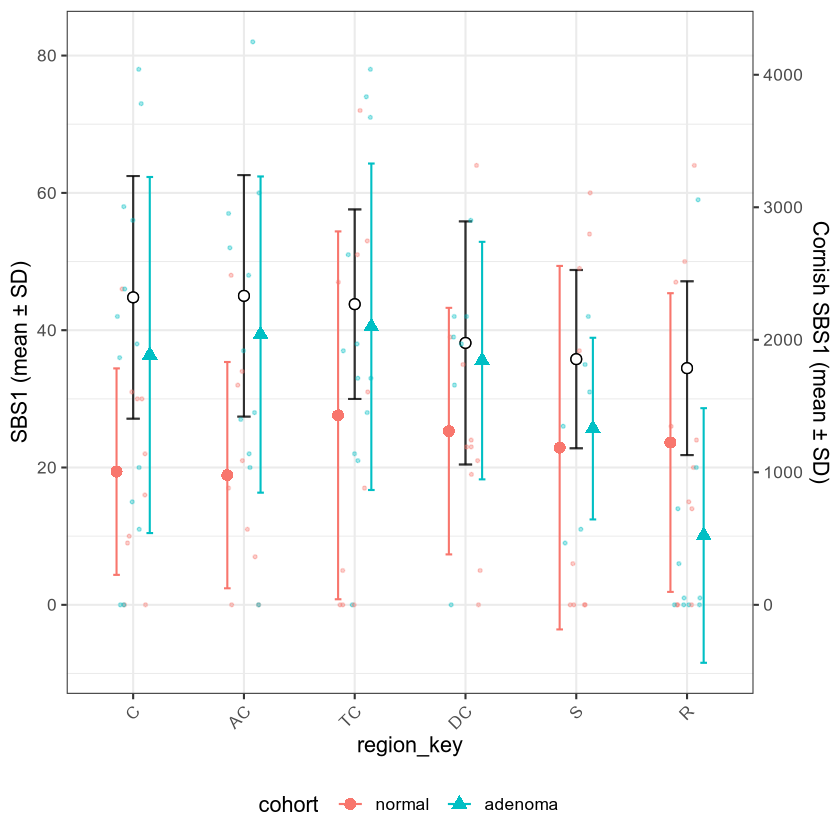

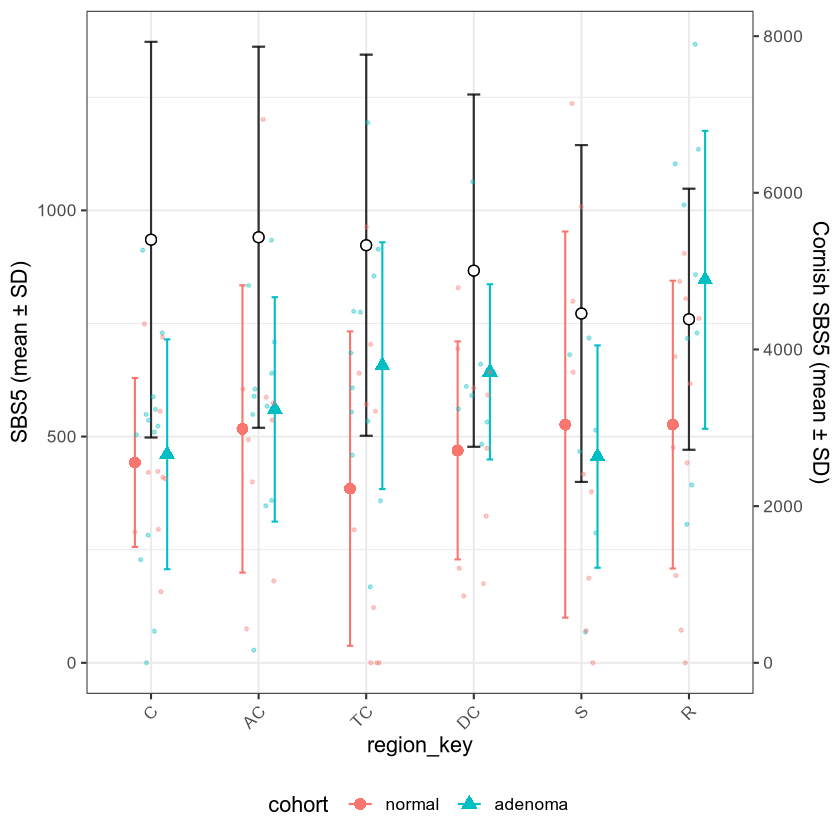

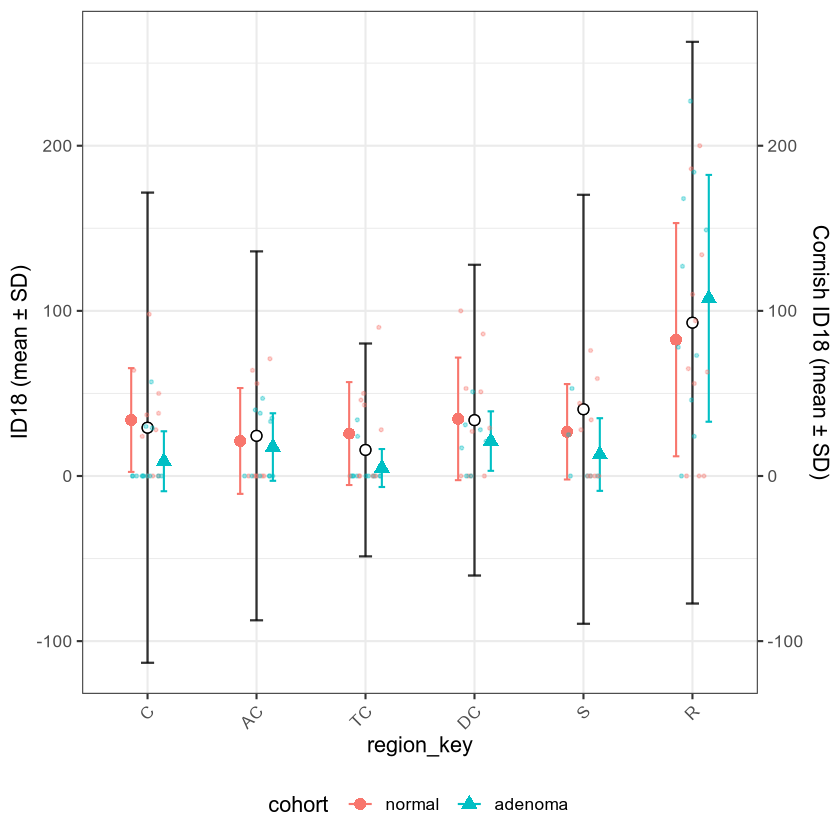

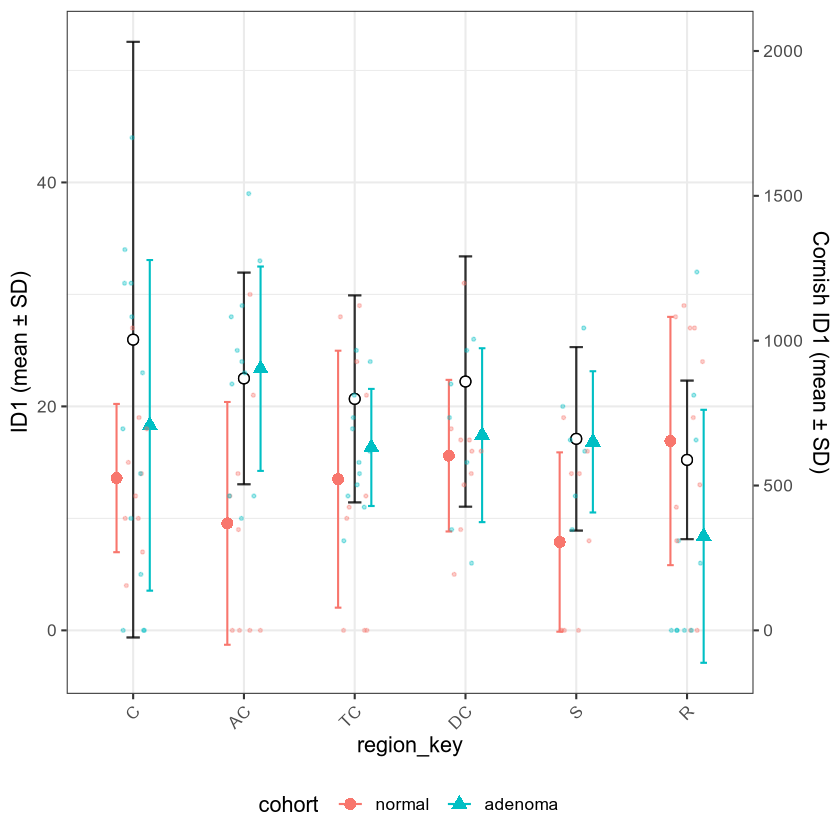

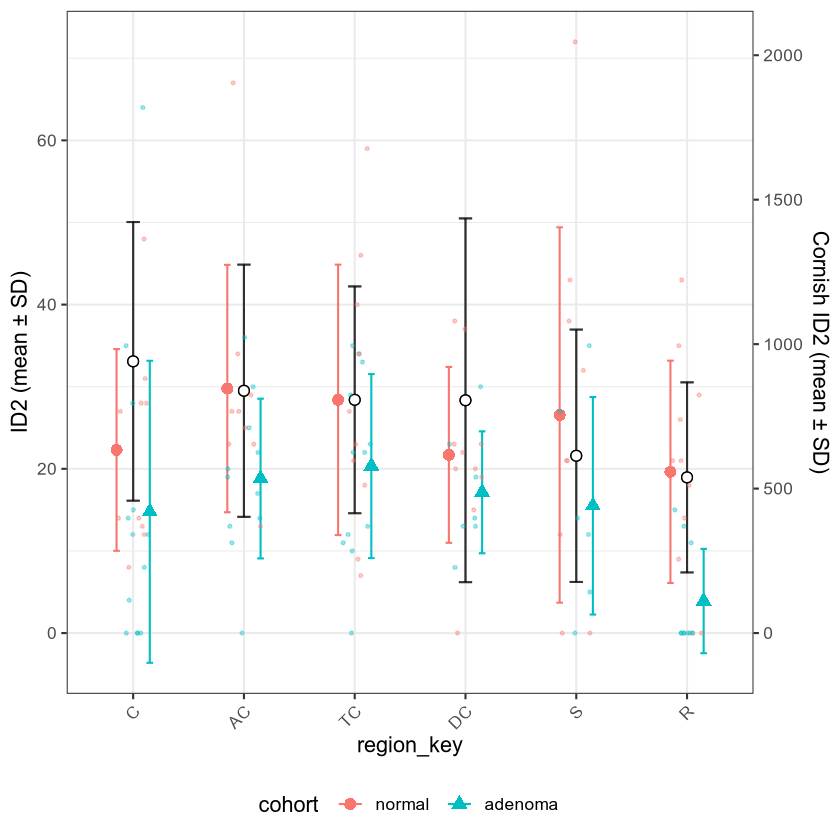

In [10]:
region_col <- "region"
cohort_col <- "cohort"

#df_raw <- Hiatt
df_raw <- Hiatt

# columns to plot: unique_IDs is used for INDELs per your message
plot_columns <- c("unique_SNVs", "total_indels", "SBS18", "SBS1", "SBS5", "ID18", "ID1", "ID2")

normalise_cohort <- function(x) {
  x0 <- ifelse(is.na(x) | x == "", NA_character_, tolower(x) %>% str_trim())
  xc <- str_replace_all(x0, "[^a-z0-9]", "")
  dplyr::case_when(
    xc %in% c("normal","n","norm","ctrl","control","healthy","nonneoplastic") ~ "normal",
    xc %in% c("adenoma","adeno","adenomatous") ~ "adenoma",
    TRUE ~ ifelse(is.na(x0), "unknown", x0)
  )
}

# desired Cornish plotting order
cornish_order <- c("cecum","asc_col","HF","trans_col","SF","desc_col","sig_col","RS","rectum")

df_base <- df_raw %>%
  mutate(
    region = as.character(.data[[region_col]]) %>% str_trim(),
    cohort_raw = if (cohort_col %in% names(df_raw)) as.character(.data[[cohort_col]]) else NA_character_,
    cohort = normalise_cohort(cohort_raw)
  ) %>%
  mutate(region = if_else(region %in% c("C","AC","HC","TC","DC","S","R"),
                          recode(region, "C"="cecum","AC"="asc_col","HC"="HF","TC"="trans_col","DC"="desc_col","S"="sig_col","R"="rectum"),
                          region))
present_regions <- intersect(unique(df_base$region), cornish_order)
if (length(present_regions) == 0) stop("No overlapping regions between your data and expected region keys.")
region_levels <- cornish_order[cornish_order %in% present_regions]
region_levels <- cornish_order[cornish_order %in% present_regions]
df_base <- df_base %>% filter(region %in% region_levels)
df_base <- df_base %>% mutate(cohort = factor(cohort, levels = c("normal","adenoma", "carcinoma")))

plot_signature <- function(value_col, cornish_df = NULL, show_jitter = TRUE) {
  if (!value_col %in% names(df_raw)) {
    message("Skipping ", value_col, " (not present in CSV).")
    return(invisible(NULL))
  }
  # numeric value vector aligned with df_base rows
  values <- as.numeric(df_raw[[value_col]][as.integer(rownames(df_base))])
  df <- df_base %>% mutate(value = values)

  summary_by_region <- df %>%
    group_by(region, cohort) %>%
    summarise(You_Mean = mean(value, na.rm = TRUE),
              You_SD   = sd(value, na.rm = TRUE),
              You_n    = sum(!is.na(value)), .groups = "drop")

  if (!is.null(cornish_df)) {
    req <- c("region_key","Cornish_Mean","Cornish_SD")
    if (!all(req %in% names(cornish_df))) stop("cornish_df must contain region_key, Cornish_Mean, Cornish_SD")
    cohorts_present <- sort(unique(summary_by_region$cohort))
    cornish_expanded <- expand.grid(region_key = region_levels, cohort = cohorts_present, stringsAsFactors = FALSE) %>%
      left_join(cornish_df, by = "region_key")
    merged <- cornish_expanded %>% left_join(summary_by_region, by = c("region_key"="region","cohort"="cohort"))
    max_your_mean <- suppressWarnings(max(merged$You_Mean, na.rm = TRUE))
    max_cornish <- suppressWarnings(max(merged$Cornish_Mean, na.rm = TRUE))
    scale_factor <- ifelse(is.na(max_your_mean) || max_your_mean <= 0, 1, {
      sf <- max_cornish / max_your_mean * 0.9
      if (is.na(sf) || sf < 1) 1 else sf
    })
    merged <- merged %>% mutate(Cornish_Mean_scaled = Cornish_Mean / scale_factor,
                                Cornish_SD_scaled = Cornish_SD / scale_factor)
  } else {
    merged <- summary_by_region %>% rename(region_key = region) %>% mutate(Cornish_Mean = NA, Cornish_SD = NA, Cornish_Mean_scaled = NA, Cornish_SD_scaled = NA)
    scale_factor <- 1
  }

  merged <- merged %>% mutate(region_key = factor(region_key, levels = region_levels))
  df <- df %>% mutate(region = factor(region, levels = region_levels))

  p <- ggplot() +
    { if (!is.null(cornish_df))
      list(
        geom_errorbar(data = merged, aes(x = region_key, ymin = Cornish_Mean_scaled - Cornish_SD_scaled, ymax = Cornish_Mean_scaled + Cornish_SD_scaled),
                      color = "black", width = 0.12, alpha = 0.55),
        geom_point(data = merged, aes(x = region_key, y = Cornish_Mean_scaled), color = "black", fill = "white", shape = 21, size = 2.6)
      ) } +
    geom_errorbar(data = merged %>% filter(!is.na(You_Mean)),
                  aes(x = region_key, ymin = You_Mean - You_SD, ymax = You_Mean + You_SD, color = cohort),
                  position = position_dodge(width = 0.6), width = 0.12) +
    geom_point(data = merged %>% filter(!is.na(You_Mean)),
               aes(x = region_key, y = You_Mean, color = cohort, shape = cohort),
               position = position_dodge(width = 0.6), size = 3)

  if (show_jitter) {
    p <- p + geom_jitter(data = df, aes(x = region, y = value, color = cohort), width = 0.15, height = 0, alpha = 0.35, size = 0.7, show.legend = FALSE)
  }

  p <- p +
    scale_x_discrete(labels = c("cecum"="C","asc_col"="AC","HF"="HC","trans_col"="TC","SF"="SF","desc_col"="DC","sig_col"="S","RS"="RS","rectum"="R")) +
    scale_y_continuous(name = paste0(value_col, " (mean ± SD)"),
                       sec.axis = sec_axis(~ . * scale_factor, name = paste0("Cornish ", value_col, " (mean ± SD)"))) +
    labs(color = "cohort", shape = "cohort") +
    theme_bw(base_size = 13) + theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "bottom")

  print(p)
  invisible(list(plot = p, merged = merged, df = df))
}

# ---- DEFINE Cornish reference data.frames (numeric values — no commas) ----
Cornish_SNVs <- data.frame(
  region_key = c("cecum","asc_col","HF","trans_col","SF","desc_col","sig_col","RS","rectum"),
  Cornish_Mean = c(14467, 14563, 14701, 14747, 12253, 13149, 12554, 10686, 11235),
  Cornish_SD   = c(6378, 6636, 7974, 6842, 5061, 7280, 6289, 4093, 5427),
  stringsAsFactors = FALSE
)

Cornish_INDELs <- data.frame(
  region_key = c("cecum","asc_col","HF","trans_col","SF","desc_col","sig_col","RS","rectum"),
  Cornish_Mean = c(1988,1804,1615,1679,1502,1734,1452,1333,1292),
  Cornish_SD   = c(1263,712,507,714,819,920,689,593,510),
  stringsAsFactors = FALSE
)

Cornish_SBS18 <- data.frame(
  region_key = c("cecum","asc_col","HF","trans_col","SF","desc_col","sig_col","RS","rectum"),
  Cornish_Mean = c(3807.98,3375.80,3482.71,3056.58,2309.67,2628.68,2226.31,2244.63,1916.16),
  Cornish_SD   = c(2523.83,1565.50,1402.03,2211.55,1803.30,2046.63,1790.99,1445.30,1394.51),
  stringsAsFactors = FALSE
)

Cornish_SBS1 <- data.frame(
  region_key = c("cecum","asc_col","HF","trans_col","SF","desc_col","sig_col","RS","rectum"),
  Cornish_Mean = c(2320.16,2331.44,2239.48,2268.68,1955.38,1976.35,1853.96,1823.53,1785.93),
  Cornish_SD   = c(915.63,911.38,618.52,715.21,583.03,917.33,672.62,705.91,655.73),
  stringsAsFactors = FALSE
)

Cornish_SBS5 <- data.frame(
  region_key = c("cecum","asc_col","HF","trans_col","SF","desc_col","sig_col","RS","rectum"),
  Cornish_Mean = c(5401.74,5432.66,5623.10,5330.62,5381.14,5006.29,4458.89,4423.61,4385.60),
  Cornish_SD   = c(2525.62,2432.57,4465.54,2432.91,2599.82,2248.67,2150.13,1451.04,1666.24),
  stringsAsFactors = FALSE
)

Cornish_ID18 <- data.frame(
  region_key = c("cecum","asc_col","HF","trans_col","SF","desc_col","sig_col","RS","rectum"),
  Cornish_Mean = c(29.25,24.32,40.19,15.78,49.52,33.82,40.39,68.62,92.84),
  Cornish_SD   = c(142.37,111.71,175.27,64.45,125.31,94.09,129.90,124.93,170.07),
  stringsAsFactors = FALSE
)

Cornish_ID1 <- data.frame(
  region_key = c("cecum","asc_col","HF","trans_col","SF","desc_col","sig_col","RS","rectum"),
  Cornish_Mean = c(1003.53,869.67,777.38,799.08,728.33,859.00,661.12,666.17,588.47),
  Cornish_SD   = c(1028.05,365.33,248.58,357.31,422.03,432.08,316.71,313.51,273.67),
  stringsAsFactors = FALSE
)

Cornish_ID2 <- data.frame(
  region_key = c("cecum","asc_col","HF","trans_col","SF","desc_col","sig_col","RS","rectum"),
  Cornish_Mean = c(940.35,838.67,808.86,807.33,715.90,805.65,613.67,556.61,538.84),
  Cornish_SD   = c(482.24,436.48,216.09,392.54,451.04,629.53,436.80,324.21,328.95),
  stringsAsFactors = FALSE
)

# ---- RUN plotting loop: pass the correct Cornish df for each column ----
for (col in plot_columns) {
  if (col == "unique_SNVs") {
    plot_signature(col, cornish_df = Cornish_SNVs, show_jitter = TRUE)
  } else if (col == "total_indels") {
    plot_signature(col, cornish_df = Cornish_INDELs, show_jitter = TRUE)
  } else if (col == "SBS18") {
    plot_signature(col, cornish_df = Cornish_SBS18, show_jitter = TRUE)
  } else if (col == "SBS1") {
    plot_signature(col, cornish_df = Cornish_SBS1, show_jitter = TRUE)
  } else if (col == "SBS5") {
    plot_signature(col, cornish_df = Cornish_SBS5, show_jitter = TRUE)
  } else if (col == "ID18") {
    plot_signature(col, cornish_df = Cornish_ID18, show_jitter = TRUE)
  } else if (col == "ID1") {
    plot_signature(col, cornish_df = Cornish_ID1, show_jitter = TRUE)
  } else if (col == "ID2") {
    plot_signature(col, cornish_df = Cornish_ID2, show_jitter = TRUE)
  } else {
    plot_signature(col, cornish_df = NULL, show_jitter = TRUE)
  }
}


Cornish with Lee-Six

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”


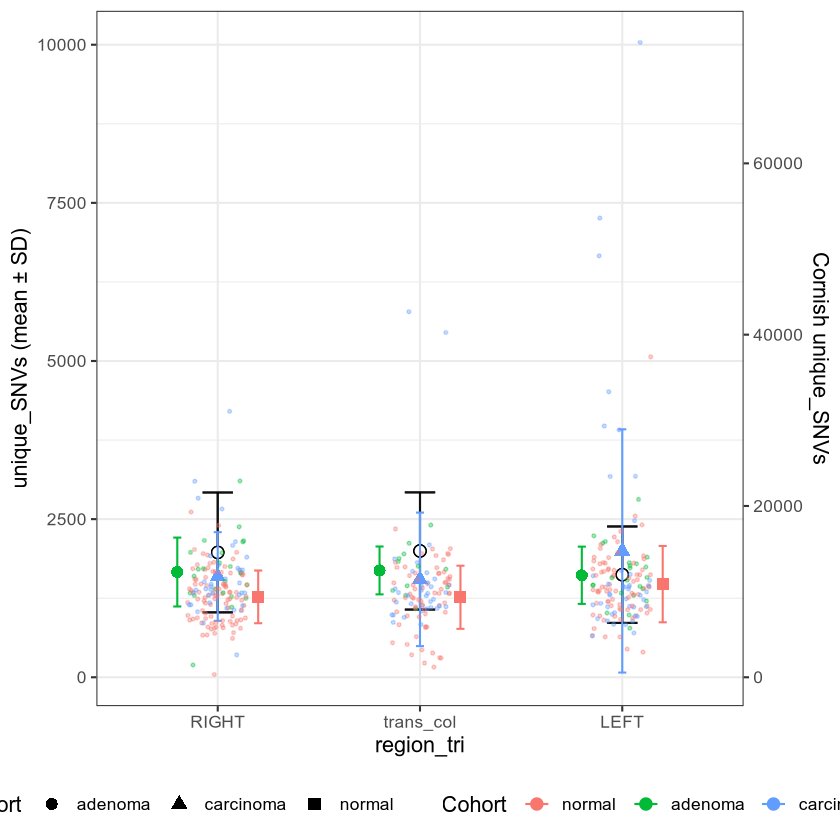

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”


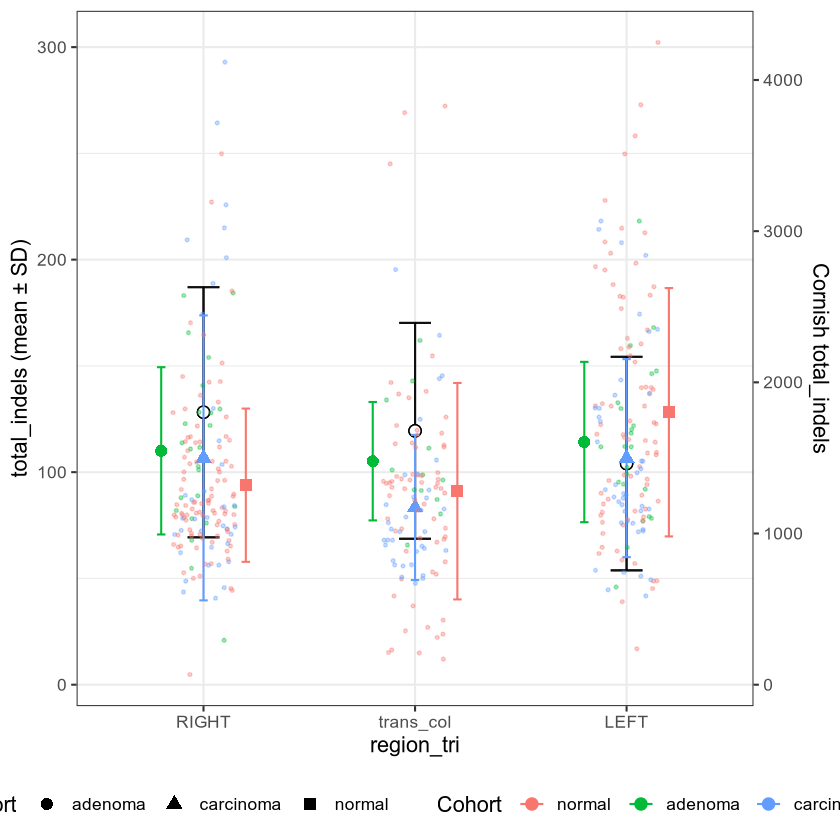

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”


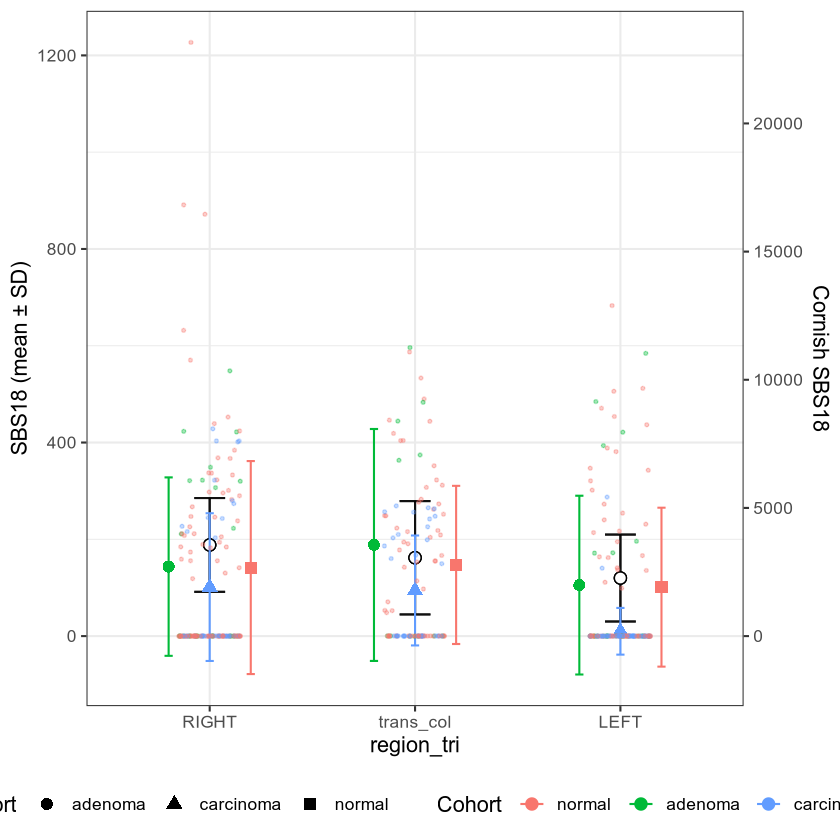

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”


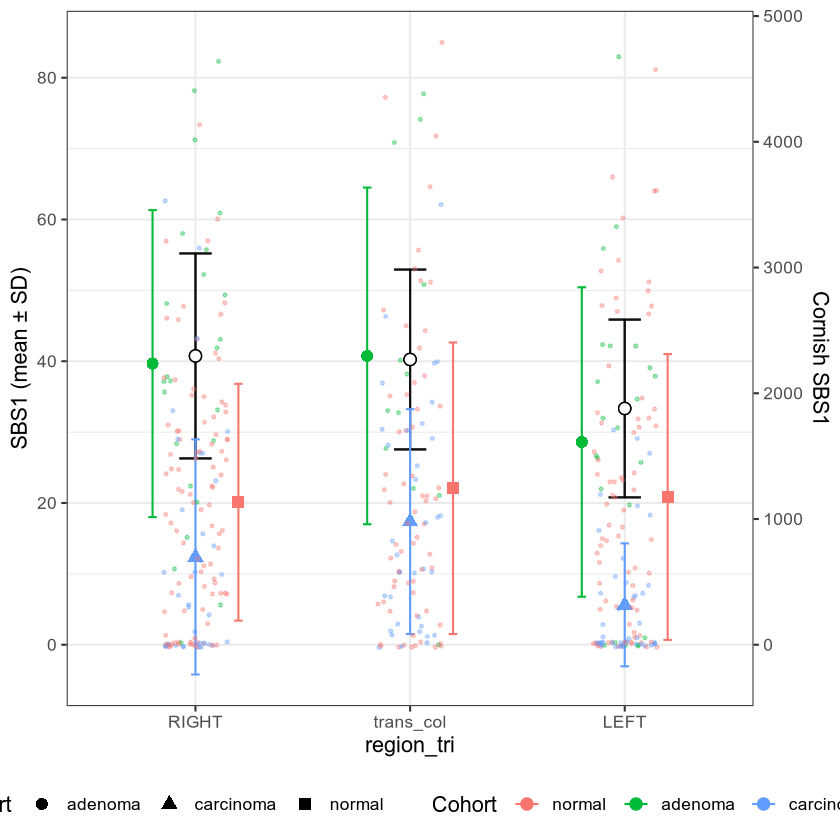

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”


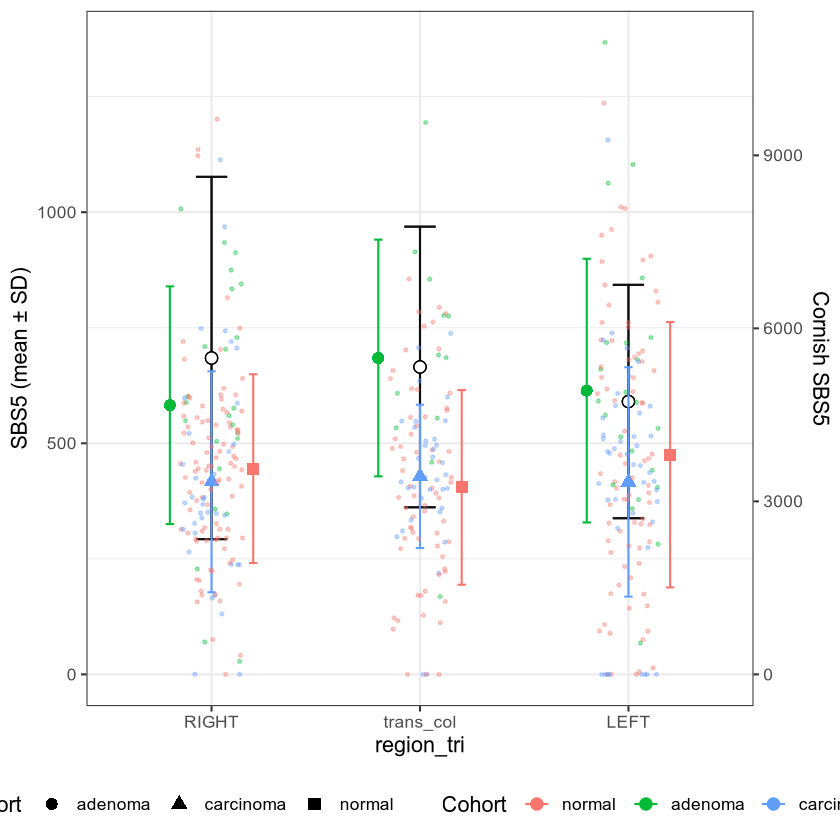

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”


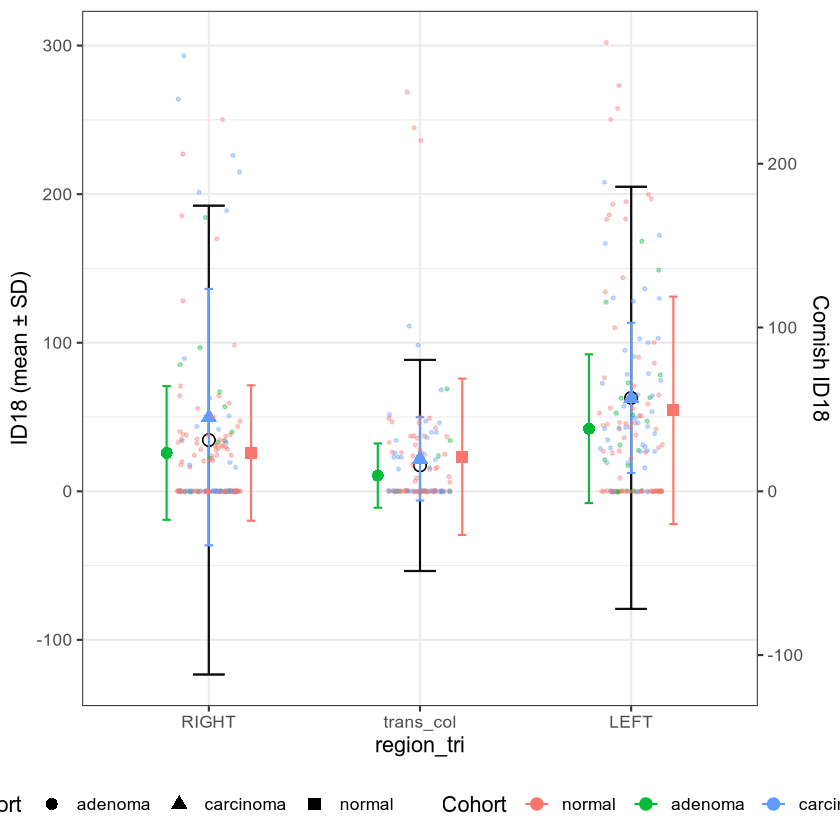

Warning message:
“Removed 18 rows containing missing values or values outside the scale range
(`geom_point()`).”


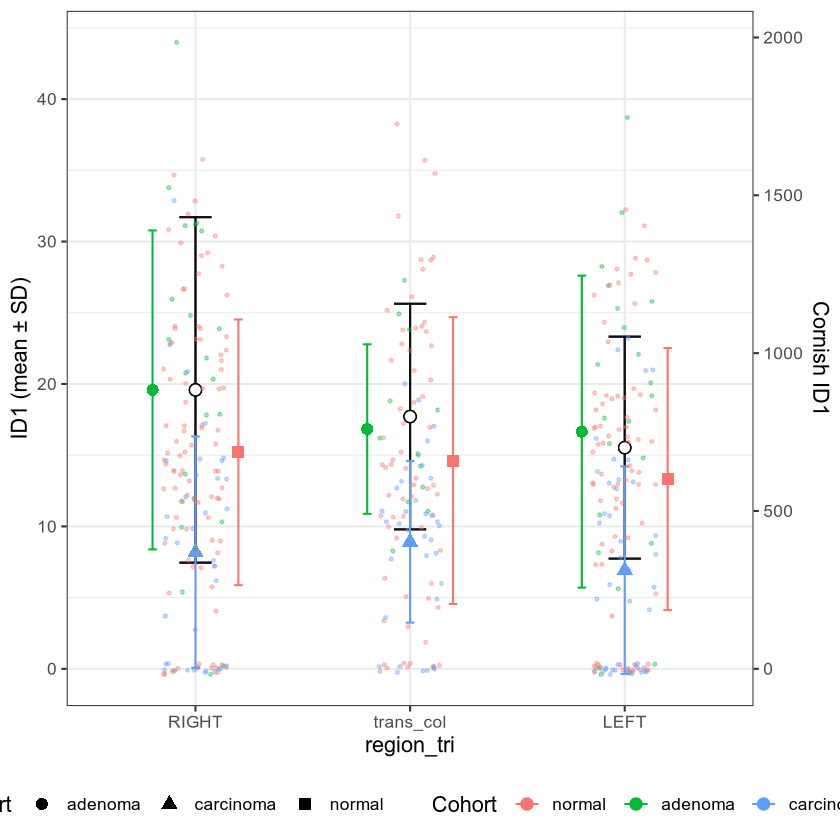

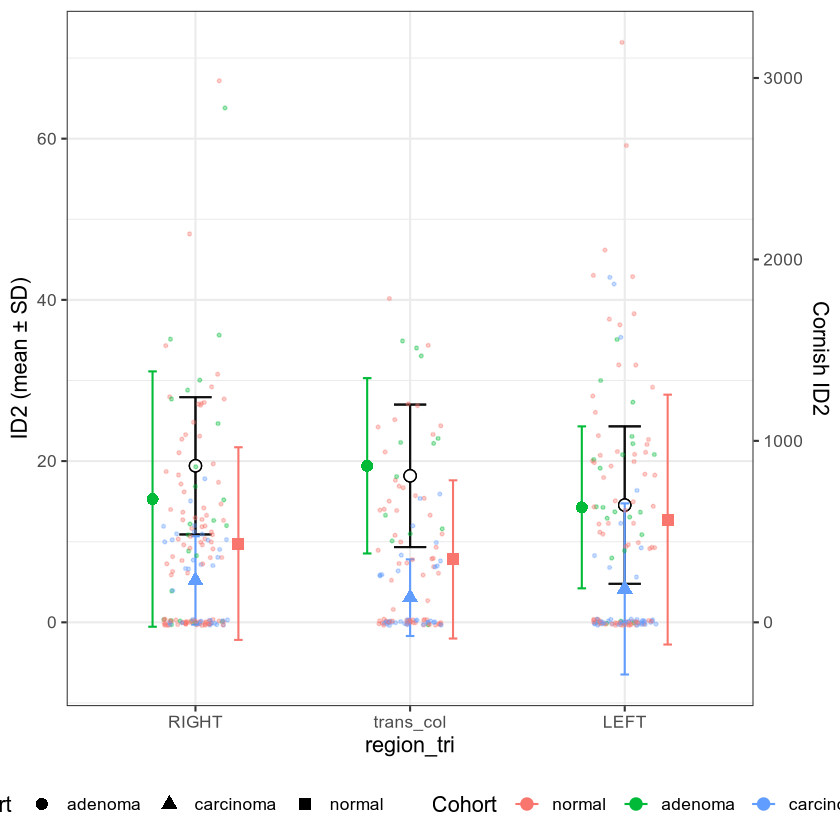

In [13]:

df_raw <- combined_df
# ---- collapse helper ----
collapse_to_tri <- function(x) {
  case_when(
    x %in% c("right", "cecum", "asc_col", "hf") ~ "RIGHT",
    x == "trans_col" ~ "trans_col",
    TRUE ~ "LEFT"
  )
}

df_base <- df_raw %>%
  mutate(
    region = as.character(.data[[region_col]]) |> str_trim() |> str_to_lower(),
    cohort_raw = if (cohort_col %in% names(df_raw)) as.character(.data[[cohort_col]]) else NA_character_,
    cohort = normalise_cohort(cohort_raw)
  ) %>%
  mutate(
    region = recode(
      region,
      "c"="cecum","ac"="asc_col","hc"="hf","tc"="trans_col",
      "dc"="desc_col","s"="sig_col","r"="rectum",
      .default = region
    )
  ) %>%
  mutate(
    region_tri = collapse_to_tri(region),
    region_tri = factor(region_tri, levels = c("RIGHT","trans_col","LEFT")),
    cohort = factor(cohort, levels = c("normal","adenoma","carcinoma"))
  )

# 🔒 sanity check
stopifnot(any(df_base$cohort == "carcinoma"))
stopifnot(!any(is.na(df_base$region_tri)))

plot_signature <- function(value_col, cornish_df = NULL, show_jitter = TRUE) {

  if (!value_col %in% names(df_raw)) return(invisible(NULL))

  df <- df_base %>%
    mutate(value = as.numeric(df_raw[[value_col]][as.integer(rownames(df_base))]))

  # ---- YOUR DATA ----
  summary_by_region <- df %>%
    group_by(region_tri, cohort) %>%
    summarise(
      You_Mean = mean(value, na.rm = TRUE),
      You_SD   = sd(value, na.rm = TRUE),
      .groups = "drop"
    )

  # ---- CORNISH ----
  if (!is.null(cornish_df)) {
    cornish_tri <- cornish_df %>%
      mutate(region_tri = collapse_to_tri(tolower(region_key))) %>%
      group_by(region_tri) %>%
      summarise(
        Cornish_Mean = mean(Cornish_Mean),
        Cornish_SD   = mean(Cornish_SD),
        .groups = "drop"
      )

    merged <- tidyr::expand_grid(
      region_tri = levels(df$region_tri),
      cohort = levels(df$cohort)
    ) %>%
      left_join(summary_by_region, by = c("region_tri","cohort")) %>%
      left_join(cornish_tri, by = "region_tri")

    scale_factor <- max(merged$Cornish_Mean, na.rm = TRUE) /
      max(merged$You_Mean, na.rm = TRUE)

    merged <- merged %>%
      mutate(
        Cornish_Mean_scaled = Cornish_Mean / scale_factor,
        Cornish_SD_scaled   = Cornish_SD / scale_factor
      )
  } else {
    merged <- summary_by_region
    scale_factor <- 1
  }

  # ---- PLOT ----
  p <- ggplot() +

    # Cornish reference
    { if (!is.null(cornish_df))
      list(
        geom_errorbar(
          data = merged,
          aes(x = region_tri,
              ymin = Cornish_Mean_scaled - Cornish_SD_scaled,
              ymax = Cornish_Mean_scaled + Cornish_SD_scaled),
          width = 0.15, color = "black", alpha = 0.6
        ),
        geom_point(
          data = merged,
          aes(x = region_tri, y = Cornish_Mean_scaled),
          shape = 21, fill = "white", color = "black", size = 3
        )
      )
    } +

    # Cohorts
    geom_errorbar(
      data = merged,
      aes(x = region_tri,
          ymin = You_Mean - You_SD,
          ymax = You_Mean + You_SD,
          color = cohort),
      position = position_dodge(0.6), width = 0.12
    ) +
    geom_point(
      data = merged,
      aes(x = region_tri, y = You_Mean,
          color = cohort, shape = cohort),
      position = position_dodge(0.6), size = 3
    )

  if (show_jitter) {
    p <- p +
      geom_jitter(
        data = df,
        aes(x = region_tri, y = value, color = cohort),
        width = 0.15, alpha = 0.35, size = 0.7,
        show.legend = FALSE
      )
  }

  p <- p +
    scale_y_continuous(
      name = paste0(value_col, " (mean ± SD)"),
      sec.axis = sec_axis(~ . * scale_factor,
                          name = paste0("Cornish ", value_col))
    ) +
    labs(color = "Cohort", shape = "Cohort") +
    theme_bw(base_size = 13) +
    theme(legend.position = "bottom")

  print(p)
}

# ---- RUN plotting loop: pass the correct Cornish df for each column ----
for (col in plot_columns) {
  if (col == "unique_SNVs") {
    plot_signature(col, cornish_df = Cornish_SNVs, show_jitter = TRUE)
  } else if (col == "total_indels") {
    plot_signature(col, cornish_df = Cornish_INDELs, show_jitter = TRUE)
  } else if (col == "SBS18") {
    plot_signature(col, cornish_df = Cornish_SBS18, show_jitter = TRUE)
  } else if (col == "SBS1") {
    plot_signature(col, cornish_df = Cornish_SBS1, show_jitter = TRUE)
  } else if (col == "SBS5") {
    plot_signature(col, cornish_df = Cornish_SBS5, show_jitter = TRUE)
  } else if (col == "ID18") {
    plot_signature(col, cornish_df = Cornish_ID18, show_jitter = TRUE)
  } else if (col == "ID1") {
    plot_signature(col, cornish_df = Cornish_ID1, show_jitter = TRUE)
  } else if (col == "ID2") {
    plot_signature(col, cornish_df = Cornish_ID2, show_jitter = TRUE)
  } else {
    plot_signature(col, cornish_df = NULL, show_jitter = TRUE)
  }
}